In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [10]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-10-dc51c845b7ff>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

In [12]:
#------------------------------Tratando os Dados-----------------------------------

dfAnomaliasFinal =  pd.DataFrame()

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
    
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp)
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid)
        x = np.array([[temp, umid, row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
        
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    print ('Anomalias: ')
    print (dfAnomalias)
    dfFinal = dfAnomalias

    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
 
    #Treino
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)

    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    
    df_test_temp = converterColunasToFloat(df_test_temp, "TEMP_MAX")
    df_test_temp = converterColunasToFloat(df_test_temp, "UMID_MED")
    
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp, dfAnomalias

In [13]:
#import random

taxaContaminacao = 5
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]
dfAnomalias = dfs[2]
print (dfAnomalias.shape)
df_training_temp = df_training_temp[df_training_temp.index.notnull()]


/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



Anomalias: 
        TEMP_MAX   UMID_MED
1.0    21.854164 -46.844462
24.0  -22.654164  55.444462
34.0  -22.554164  63.244462
189.0 -20.654164 -46.644462
200.0 -27.954164  57.544462
201.0 -27.754164  62.644462
218.0  21.454164 -52.444462
229.0 -21.054164 -52.444462
277.0  28.054164 -71.244462
286.0  23.454164 -67.044462
296.0 -21.854164  58.444462
303.0 -23.154164  55.844462
306.0  24.454164 -55.444462
312.0 -21.054164 -66.944462
363.0  22.954164 -50.344462
366.0  22.054164 -46.444462
410.0 -23.754164  49.044462
475.0  22.154164 -59.444462
492.0  21.854164 -46.844462
546.0 -27.454164  55.044462
620.0  21.754164  47.944462
628.0  22.054164  46.044462
639.0 -21.354164 -49.344462
667.0  22.454164 -50.544462
675.0  24.954164 -51.644462
680.0  21.254164 -63.344462
703.0  21.854164 -52.344462
714.0  22.254164 -64.444462
721.0  23.054164 -49.844462
(29, 2)


        TEMP_MAX   UMID_MED
58.0   12.029808  69.607758
263.0  15.829808 -92.407758
272.0  10.500000 -30.800000
280.0 -12.429808  64.207758
288.0  17.929808 -74.107758
318.0  15.229808 -90.607758
338.0  -9.900000  40.600000
350.0 -16.129808  67.207758
381.0  11.729808  64.507758
388.0  16.129808 -70.407758
596.0  11.629808  66.907758
648.0  15.529808 -91.107758
698.0  17.929808 -77.907758


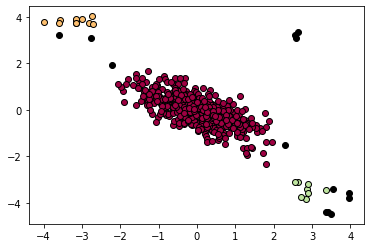

In [19]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df_used, eps, min_samples):
    X = np.array(df_used)
    X = StandardScaler().fit_transform(df_used)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='auto').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df_used[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    outliers = outliers[outliers.index.notnull()]
    
    #print('Outliers encontrados: ')
    #print (outliers.shape)
    #print (outliers)

    #plt.title('Número estimado de clusters: %d' % n_clusters_)
    #plt.xlabel("TEMP_MAX")
    #plt.ylabel("UMID_MED")
    #plt.show()
    return outliers

eps = 0.5
min_samples = 5
df_training_temp = df_training_temp[df_training_temp.index.notnull()]
outliers = dbscan_part1(df_training_temp, eps, min_samples)
dfOutliersErrados = pd.concat([outliers, dfAnomalias]).drop_duplicates(keep=False)
print (outliers)

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

dfTemp = pd.DataFrame()
colTemp = ['TEMP_MAX']
dfTemp = pd.DataFrame(columns=colTemp)

dfTemp['TEMP_MAX'] = df_training_temp['TEMP_MAX']

counter = int((dfTemp.shape[0] * 30) / 100)
df_test_temp = dfTemp.sample(n=counter, random_state=1)
df_train_temp = pd.concat([dfTemp, df_test_temp]).drop_duplicates(keep=False)

model=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, max_features=1.0).fit(dfTemp[['TEMP_MAX']])

dfTemp['scores']=model.decision_function(dfTemp[['TEMP_MAX']])
dfTemp['anomaly']=model.predict(dfTemp[['TEMP_MAX']])

anomalyTemp=dfTemp.loc[dfTemp['anomaly']==-1]
anomaly_index=list(anomalyTemp.index)

print (dfTemp.shape[0])
print(anomalyTemp.head(n=80).to_string(index=True))

dfUmid = pd.DataFrame()
colUmid = ['UMID_MED']
dfUmid = pd.DataFrame(columns=colUmid)

dfUmid['UMID_MED'] = df_training_temp['UMID_MED']

model=IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0).fit(dfUmid[['UMID_MED']])

dfUmid['scores']=model.decision_function(dfUmid[['UMID_MED']])
dfUmid['anomaly']=model.predict(dfUmid[['UMID_MED']])

anomalyUmid=dfUmid.loc[dfUmid['anomaly']==-1]
anomaly_index=list(anomalyUmid.index)

#print ('Anomalias Temperatura:')
#print (anomalyTemp)

#print ('Anomalias Umidade:')
#print (anomalyUmid)

dfTempUmidAnomalies = pd.DataFrame({'TEMP_MAX':anomalyTemp['TEMP_MAX'], 'UMID_MED': anomalyUmid['UMID_MED']})


611
        TEMP_MAX    scores  anomaly
5.0    -9.700000 -0.001396       -1
15.0   15.802652 -0.057771       -1
58.0  -12.402652 -0.001647       -1
64.0   16.302652 -0.071908       -1
188.0 -11.902652 -0.024358       -1
224.0 -12.702652 -0.001907       -1
266.0  13.202652 -0.018510       -1
302.0  14.302652 -0.019790       -1
303.0 -13.102652 -0.013604       -1
308.0  18.702652 -0.125479       -1
331.0  -9.500000 -0.001396       -1
391.0  15.602652 -0.055843       -1
395.0  16.602652 -0.087833       -1
403.0 -15.002652 -0.069796       -1
434.0 -13.402652 -0.020889       -1
438.0   8.600000 -0.003389       -1
487.0  14.602652 -0.031313       -1
528.0 -14.102652 -0.044896       -1
539.0 -18.102652 -0.111857       -1
540.0  12.002652 -0.030916       -1
559.0  -9.700000 -0.001396       -1
568.0 -14.902652 -0.066930       -1
584.0 -10.800000 -0.023181       -1
586.0 -20.002652 -0.123895       -1
600.0 -14.402652 -0.048809       -1
650.0  11.902652 -0.030819       -1
661.0 -12.402652 -0.0016

In [19]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from numpy import quantile, where, random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from numpy import where

%matplotlib inline

df = df_training_temp[["TEMP_MAX", "UMID_MED"]]
counter = int((df.shape[0] * 30) / 100)
df_test = df.sample(n=counter, random_state=1)
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.5).fit_predict(df)

y_pred=ocsvm.predict(df)

dfAnomaly = where(y_pred == -1)


print (df.iloc[dfAnomaly])
print ()
df_train.sort_index(inplace=True)
print (df_train)
print ()
df_test.sort_index(inplace=True)
print (df_test)


        TEMP_MAX   UMID_MED
3.0     5.600000  -3.000000
4.0    -0.400000  13.600000
5.0    -7.100000  32.200000
8.0    -0.800000  -6.800000
10.0    0.600000  -4.000000
...          ...        ...
722.0   4.700000 -16.900000
723.0   1.600000  -3.400000
724.0   6.300000 -13.300000
726.0   0.900000 -18.000000
728.0  16.797561 -57.890109

[316 rows x 2 columns]

       TEMP_MAX  UMID_MED
2.0         2.2      -6.7
3.0         5.6      -3.0
7.0        -0.7      -4.4
8.0        -0.8      -6.8
9.0        -0.2      -6.2
...         ...       ...
723.0       1.6      -3.4
724.0       6.3     -13.3
727.0      -1.5      -2.6
729.0       2.1     -10.5
730.0      -2.9       3.0

[424 rows x 2 columns]

        TEMP_MAX   UMID_MED
1.0     2.500000  -2.500000
4.0    -0.400000  13.600000
5.0    -7.100000  32.200000
6.0    -1.700000  13.300000
10.0    0.600000  -4.000000
...          ...        ...
719.0  -0.500000  -2.700000
722.0   4.700000 -16.900000
725.0   5.500000 -15.400000
726.0   0.900000 -18.0

In [22]:
from sklearn.svm import OneClassSVM
from numpy import where

df = df_training_temp[["TEMP_MAX", "UMID_MED"]]
counter = int((df.shape[0] * 30) / 100)
testX = df.sample(n=counter, random_state=1)
trainX = pd.concat([df, df_test]).drop_duplicates(keep=False)

clf = OneClassSVM(kernel='rbf', gamma='auto', nu=0.5)
clf.fit(trainX)
y_pred_train = clf.predict(trainX)
y_pred_test = clf.predict(testX)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

dfAnomaly = where(y_pred_test == -1)

print (df.iloc[dfAnomaly])

       TEMP_MAX  UMID_MED
1.0         2.9      -1.2
2.0         2.8      -2.9
3.0         3.0      -2.8
4.0        -0.1      11.9
6.0        -3.2      13.5
...         ...       ...
296.0      -4.1      25.0
298.0       2.0      -7.8
299.0       4.1      -5.5
300.0       6.3     -15.9
301.0       5.1     -28.3

[125 rows x 2 columns]


In [57]:
import matplotlib.pyplot as plot
from gtda.plotting import plot_point_cloud

from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

from sklearn import datasets
from sklearn.decomposition import PCA

data = np.array(df_training_temp)
plot_point_cloud(data)



In [77]:
#data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

filter_func = Projection(columns=[0, 1])
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
clusterer = DBSCAN(eps=5)

n_jobs = 1

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

pca = PCA(n_components=1)

fig = plot_static_mapper_graph(
    pipe, data, color_data=data, color_features=pca
)
fig.show(config={'scrollZoom': True})

df = pd.DataFrame(data, columns=["x", "y"])

graph = pipe.fit_transform(data)

node_id = 27
node_elements = graph.vs["node_elements"]

print(f"""
Node ID: {node_id}
Node elements: {node_elements[node_id]}
Data points: {data[node_elements[node_id]]}
""")


Node ID: 27
Node elements: [293]
Data points: [[-4.5 33.3]]

